# **Project 2 Code and Visualizations**

 The following code provides the workflow, functions, analysis, and insights into Project 2 for group Justus von Liebig

Project Members: Allison Nguyen, Emily Wu, Wendy Peng, Emma Azhan, Magaly Santos, Noah Mujica

# Table of Contents

- **Data Setup**

- **Deliverable [A] - Population of Interest**

- **Deliverable [A] - Dietary Reference Intakes**

- **Deliverable [A] - Food Prices**

- **Deliverable [A] - Nutritional Content**

- **Deliverable [A] - Solution**

- **Deliverable [B] - Solution Sensitivity**

- **Deliverable [B] - Solution Total Cost**

- **Unit Tests**

## Data Setup

In [1]:
%pip install eep153_tools
%pip install python_gnupg
%pip install -U gspread_pandas

  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2.2.3
Note: you may need to restart the kernel to use updated packages.


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from  scipy.optimize import linprog as lp
from eep153_tools.sheets import read_sheets

In [3]:
def format_id(id,zeropadding=0):
    """Nice string format for any id, string or numeric.

    Optional zeropadding parameter takes an integer
    formats as {id:0z} where
    """
    if pd.isnull(id) or id in ['','.']: return None

    try:  # If numeric, return as string int
        return ('%d' % id).zfill(zeropadding)
    except TypeError:  # Not numeric
        return id.split('.')[0].strip().zfill(zeropadding)
    except ValueError:
        return None

data_url = "https://docs.google.com/spreadsheets/d/1qCxS3mh29miTIFQJ9IDs4cKUjgepZU37SbJO9v0_fOE/edit?gid=1569303630#gid=1569303630"

In [4]:
recipes = read_sheets(data_url, sheet="recipes")
recipes = (recipes
           .assign(parent_foodcode = lambda df: df["parent_foodcode"].apply(format_id),
                   ingred_code = lambda df: df["ingred_code"].apply(format_id))
           .rename(columns={"parent_desc": "recipe"}))

nutrition = (read_sheets(data_url, sheet="nutrients")
             .assign(ingred_code = lambda df: df["ingred_code"].apply(format_id)))

recipes.head()


,parent_foodcode,recipe,ingred_code,ingred_desc,ingred_wt
0,11340000,"Imitation milk, non-soy, sweetened",43543,"Milk, imitation, non-soy",100.0
1,11460150,"Yogurt, frozen, NS as to flavor, lowfat milk",1298,"Yogurt, frozen, flavors other than chocolate, ...",100.0
2,11460160,"Yogurt, frozen, chocolate, lowfat milk",1117,"Yogurt, plain, low fat, 12 grams protein per 8...",81.8
3,11460160,"Yogurt, frozen, chocolate, lowfat milk",19166,"Cocoa, dry powder, unsweetened, processed with...",5.2
4,11460160,"Yogurt, frozen, chocolate, lowfat milk",19335,"Sugars, granulated",13.0


In [5]:
# Control and Cancer Diets
control_diet = read_sheets(data_url, sheet="control diet")
cancer_diet = read_sheets(data_url, sheet="cancer diet")

control_diet["parent_foodcode"] = control_diet["parent_foodcode"].astype(str)
cancer_diet["parent_foodcode"] = cancer_diet["parent_foodcode"].astype(str)
recipes["parent_foodcode"] = recipes["parent_foodcode"].astype(str)


control_diet_df = recipes[recipes["parent_foodcode"].isin(control_diet["parent_foodcode"])]
cancer_diet_df = recipes[recipes["parent_foodcode"].isin(cancer_diet["parent_foodcode"])]


cancer_diet.head()

,idex,parent_description,parent_foodcode,food group covered,nutrient group
0,1,"Bread, French or Vienna, whole wheat",51301540,Whole wheat bread,carbohydrates
1,2,"Lasagna with meat, whole wheat noodles",58130610,Whole wheat pasta,carbohydrates
2,3,"Oatmeal, instant, plain, made with milk, fat ...",56203097,Oatmeal,carbohydrates
3,4,Pinto beans and brown rice,58161323,Brownrice,carbohydrates
4,5,"Cheeseburger, 1 medium patty, with condiments,...",27510253,Whole wheat bread,carbohydrates


In [6]:
display(nutrition.head())

,ingred_code,Ingredient description,Capric acid,Lauric acid,Myristic acid,Palmitic acid,Palmitoleic acid,Stearic acid,Oleic acid,Linoleic Acid,...,Vitamin B12,"Vitamin B-12, added",Vitamin B6,Vitamin C,Vitamin D,Vitamin E,"Vitamin E, added",Vitamin K,Water,Zinc
0,1001,"Butter, salted",2.529,2.587,7.436,21.697,0.961,9.999,19.961,2.728,...,0.17,0.0,0.003,0.0,0.0,2.32,0.0,7.0,15.87,0.09
1,1002,"Butter, whipped, with salt",2.039,2.354,7.515,20.531,1.417,7.649,17.370,2.713,...,0.07,0.0,0.008,0.0,0.0,1.37,0.0,4.6,16.72,0.05
2,1003,"Butter oil, anhydrous",2.495,2.793,10.005,26.166,2.228,12.056,25.026,2.247,...,0.01,0.0,0.001,0.0,0.0,2.80,0.0,8.6,0.24,0.01
3,1004,"Cheese, blue",0.601,0.491,3.301,9.153,0.816,3.235,6.622,0.536,...,1.22,0.0,0.166,0.0,0.5,0.25,0.0,2.4,42.41,2.66
4,1005,"Cheese, brick",0.585,0.482,3.227,8.655,0.817,3.455,7.401,0.491,...,1.26,0.0,0.065,0.0,0.5,0.26,0.0,2.5,41.11,2.60


**Deliverable [A] - Population of Interest**


The primary population of interest we hope to analyse is breast cancer, colorectal cancer and leukemia patients in the United States aged 50 and up, standardising across sex and racial demographics. We aim to standardise the ideal diet for each of these cancer types prescribed to patients, extrapolating from macronutrient recommendations to get a best-estimation of a generic patient diet. To create a baseline of comparison for each of these three test groups, we hope to utilise the average American dietary information as a control. This will consist of the best-estimated diet of the average American aged 50 and up, simplifying across sex and race. By comparing these three test groups against the control, we hope to derive meaningful conclusions about the difference in the minimum-cost diets for cancer patients compared to those without cancer.

**Deliverable [A] - Dietary Reference Intakes**

Write a function that takes as arguments the characteristics of a person (e.g., age, sex) and returns a `pandas.Series' of Dietary Reference Intakes (DRI's) or "Recommended Daily Allowances" (RDA) of a variety of nutrients appropriate for your population of interest.

In [7]:
rda = read_sheets(data_url, sheet="rda")
rda = rda.set_index("Nutrient")
#rda.columns, rda.head()

In [8]:
def diet_ref(sex, cancer_group='control', age_group="51U"):
    
    col_name = f"{sex}_{age_group}_{cancer_group}"

    if col_name not in rda.columns:
        raise ValueError(f"Column '{col_name}' not found in the dataset.")

    return rda[col_name]
        

In [10]:
diet_ref("Female", cancer_group="leukemia").head()

Nutrient
Energy           1800.0
Protein            80.0
Carbohydrate      225.0
Dietary Fiber      22.4
Linoleic Acid      11.0
Name: Female_51U_leukemia, dtype: float64

**[A] Data on prices for different foods**



In [11]:
prices = read_sheets(data_url, sheet="prices")[["food_code", "year", "price"]]

prices["food_code"] = prices["food_code"].apply(format_id)

prices = prices.set_index(["year", "food_code"])
#print(prices.index.levels[0])

# we'll focus on the latest price data
prices = prices.xs("2017/2018", level="year")

# drop rows of prices where the price is "NA"
prices = prices.dropna(subset="price")

print(f"We have prices for {prices.shape[0]} unique recipes (FNDDS food codes)")

We have prices for 4435 unique recipes (FNDDS food codes)


In [12]:
prices.head()

,price
food_code,
11100000,0.100484
11111000,0.09828
11112110,0.092085
11112210,0.090914
11113000,0.092441


In [13]:
def process_diet_data(diet_df, nutrition_df, prices_df):

    # Normalize weights to percentage terms
    diet_df["ingred_wt"] = diet_df["ingred_wt"] / diet_df.groupby("parent_foodcode")["ingred_wt"].transform("sum")

    # Merge with nutrition data to get nutrient profiles
    df = diet_df.merge(nutrition_df, how="left", on="ingred_code")

    # Multiply nutrients per 100g by the weight of that ingredient
    numeric_cols = list(df.select_dtypes(include=["number"]).columns)
    numeric_cols.remove("ingred_wt")
    df[numeric_cols] = df[numeric_cols].mul(df["ingred_wt"], axis=0)

    # Sum nutrients at the parent foodcode level
    df = df.groupby("parent_foodcode").agg({**{col: "sum" for col in numeric_cols}, "recipe": "first"})

    # Rename index for clarity
    df.index.name = "recipe_id"

    # Extract food names
    food_names = df["recipe"]

    # Align recipes and prices based on common indices
    common_recipes = df.index.intersection(prices_df.index)
    df = df.loc[common_recipes]
    prices = prices_df.loc[common_recipes]

    # Rename prices index with actual food names
    prices.index = prices.index.map(food_names)

    # Transpose the final nutrient table
    A_all = df.T

    return df, prices, A_all


In [14]:
# Process recipes diet
recipes_df, recipes_prices, recipes_A_all = process_diet_data(recipes, nutrition, prices)

# Process control diet
control_df, control_prices, control_A_all = process_diet_data(control_diet_df, nutrition, prices)

# Process cancer diet
cancer_df, cancer_prices, cancer_A_all = process_diet_data(cancer_diet_df, nutrition, prices)

/tmp/ipykernel_75/1679704066.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diet_df["ingred_wt"] = diet_df["ingred_wt"] / diet_df.groupby("parent_foodcode")["ingred_wt"].transform("sum")
/tmp/ipykernel_75/1679704066.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diet_df["ingred_wt"] = diet_df["ingred_wt"] / diet_df.groupby("parent_foodcode")["ingred_wt"].transform("sum")


In [15]:
tol = 1e-6
def min_cost(sex, cancer_group, age_group="51U", A_all=cancer_A_all, p=cancer_prices):
    
    col_name = f"{sex}_{age_group}_{cancer_group}"
    #print(col_name)
    if cancer_group == " control":
        A_all = control_A_all
        p = control_prices

    # create lower bounds and upper bounds.
    bmin = rda.loc[rda['Constraint Type'].isin(['RDA', 'AI']), col_name]
    bmax = rda.loc[rda['Constraint Type'].isin(['UL']), col_name]
    
    # reindex ensures we only keep nutrients in bmin/bmax
    Amin = A_all.reindex(bmin.index).dropna(how='all')
    Amax = A_all.reindex(bmax.index).dropna(how='all')
    
    b = pd.concat([bmin, -bmax])
    A = pd.concat([Amin, -Amax])

    #print(f"{bmin.shape=}")
    #print(f"{Amin.shape=}")
    #print(f"{bmax.shape=}")
    #print(f"{Amax.shape=}")
    #print(f"{b.shape=}")
    #print(f"{A.shape=}")
    #print(f"{prices.shape=}")

    tol = 0.01 #1e-6 # Numbers in solution smaller than this (in absolute value) treated as zeros
    result = lp(p, -A, -b, method='highs')
    #print(result)
    print(f"Cost of diet for {col_name} is ${result.fun:.2f} per day.")

    return result

In [16]:
#Example
result_example = min_cost("Female", cancer_group='colon', age_group="51U")

Cost of diet for Female_51U_colon is $5.10 per day.


***Is our solution edible?***

In [17]:
diet = pd.Series(result_example.x,index=cancer_prices.index)

print("\nYou'll be eating (in 100s of grams or milliliters):")
print(round(diet[diet >= tol], 2))


You'll be eating (in 100s of grams or milliliters):
Milk, low fat (1%)                                                                        19.48
Edamame, cooked                                                                            0.15
Sunflower seeds, plain, unsalted                                                           0.45
Flax seeds                                                                                 1.14
Sweet potato, baked, peel eaten, no added fat                                              3.49
Lettuce, salad with assorted vegetables including tomatoes and/or carrots, no dressing     0.66
dtype: float64


***Control Diets***

In [18]:
control_male = min_cost("Male", cancer_group='control', age_group="51U")

Cost of diet for Male_51U_control is $5.49 per day.


In [19]:
control_female = min_cost("Female", cancer_group='control', age_group="51U")

Cost of diet for Female_51U_control is $4.49 per day.


***Colon Cancer Diets***

In [20]:
colon_male = min_cost("Male", cancer_group='colon', age_group="51U")

Cost of diet for Male_51U_colon is $5.76 per day.


In [21]:
colon_female = min_cost("Female", cancer_group='colon', age_group="51U")

Cost of diet for Female_51U_colon is $5.10 per day.


***Breast Cancer Diets***


In [22]:
breast_male = min_cost("Male", cancer_group='breast', age_group="51U")

Cost of diet for Male_51U_breast is $5.62 per day.


In [23]:
breast_female = min_cost("Female", cancer_group='colon', age_group="51U")

Cost of diet for Female_51U_colon is $5.10 per day.


***Leukemia Cancer Diets***

In [24]:
leukemia_male = min_cost("Male", cancer_group='leukemia', age_group="51U")

Cost of diet for Male_51U_leukemia is $12.91 per day.


In [25]:
leukemia_female = min_cost("Female", cancer_group='leukemia', age_group="51U")

Cost of diet for Female_51U_leukemia is $11.72 per day.


In [26]:
leu_diet = pd.Series(leukemia_female.x,index=cancer_prices.index)

print("\nYou'll be eating (in 100s of grams or milliliters):")
print(round(diet[diet >= tol], 2))


You'll be eating (in 100s of grams or milliliters):
Milk, low fat (1%)                                                                        19.48
Edamame, cooked                                                                            0.15
Sunflower seeds, plain, unsalted                                                           0.45
Flax seeds                                                                                 1.14
Sweet potato, baked, peel eaten, no added fat                                              3.49
Lettuce, salad with assorted vegetables including tomatoes and/or carrots, no dressing     0.66
dtype: float64


***Minimum Cost Diet Visualizations***

In [28]:
categories = [
    ("Male", "control", "51U", control_male.fun),
    ("Female", "control", "51U", control_female.fun),
    ("Male", "colon", "51U", colon_male.fun),
    ("Female", "colon", "51U", colon_female.fun),
    ("Male", "breast", "51U", breast_male.fun),
    ("Female", "breast", "51U", breast_female.fun),
    ("Male", "leukemia", "51U", leukemia_male.fun),
    ("Female", "leukemia", "51U", leukemia_female.fun),
]

df_min_cost = pd.DataFrame(categories, columns=["Sex", "Cancer Group", "Age Group", "Min Cost ($/day)"])

In [29]:
df_min_cost

,Sex,Cancer Group,Age Group,Min Cost ($/day)
0,Male,control,51U,5.491999
1,Female,control,51U,4.490333
2,Male,colon,51U,5.761796
3,Female,colon,51U,5.100934
4,Male,breast,51U,5.619787
5,Female,breast,51U,5.100934
6,Male,leukemia,51U,12.914518
7,Female,leukemia,51U,11.716003


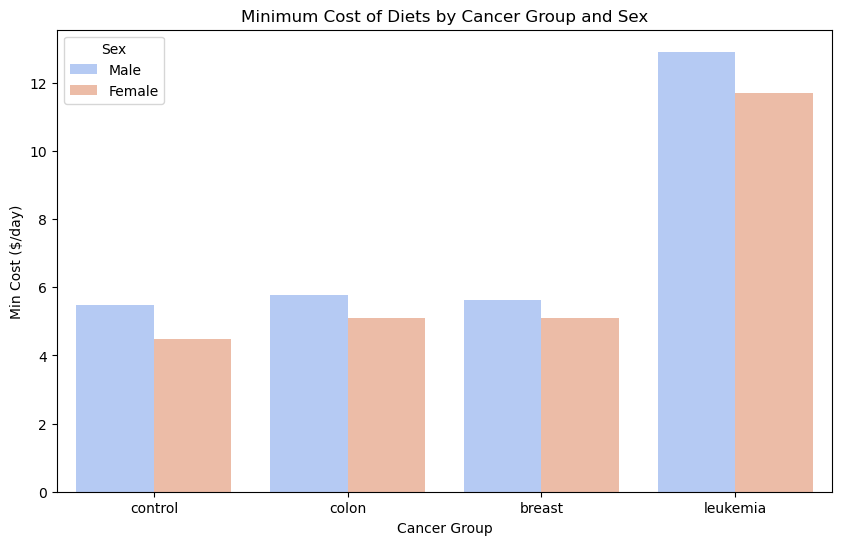

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_min_cost, x="Cancer Group", y="Min Cost ($/day)", hue="Sex", palette="coolwarm")
plt.xlabel("Cancer Group")
plt.ylabel("Min Cost ($/day)")
plt.title("Minimum Cost of Diets by Cancer Group and Sex")
plt.legend(title="Sex")
plt.show()

In [36]:
rda.head()

,Nutrient Type,Unit,Constraint Type,Female_51U_control,Male_51U_control,Female_51U_colon,Male_51U_colon,Female_51U_breast,Male_51U_breast,Female_51U_leukemia,Male_51U_leukemia
Nutrient,,,,,,,,,,,
Energy,Macro,kcal,RDA,1600.0,2000.0,1800.0,2100.0,1800.0,2100.0,1800.0,2100.0
Protein,Macro,g,RDA,46.0,56.0,105.0,115.0,80.0,105.0,80.0,105.0
Carbohydrate,Macro,g,RDA,130.0,130.0,130.0,130.0,275.0,275.0,225.0,225.0
Dietary Fiber,Macro,g,RDA,22.4,28.0,50.0,55.0,22.4,28.0,22.4,28.0
Linoleic Acid,Macro,g,AI,11.0,14.0,11.0,14.0,11.0,14.0,11.0,14.0


In [72]:
df_grouped = df_min_cost.groupby(["Cancer Group", "Sex"], sort=False)[["Min Cost ($/day)"]].mean().unstack().reset_index()
df_grouped.columns = df_grouped.columns.droplevel(0)

df_grouped = df_grouped.rename(columns={"": "Cancer Group", "Female": "Female Cost", "Male": "Male Cost"})
df_grouped["Cost Difference (Male - Female)"] = df_grouped["Male Cost"] - df_grouped["Female Cost"]
df_grouped["% Difference (Male - Female)"] = (df_grouped["Male Cost"] - df_grouped["Female Cost"]) / df_grouped["Female Cost"] * 100

df_grouped.head()

Sex,Cancer Group,Male Cost,Female Cost,Cost Difference (Male - Female),% Difference (Male - Female)
0,control,5.491999,4.490333,1.001666,22.307166
1,colon,5.761796,5.100934,0.660863,12.955718
2,breast,5.619787,5.100934,0.518854,10.171738
3,leukemia,12.914518,11.716003,1.198515,10.229728


## 

/tmp/ipykernel_75/507918500.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


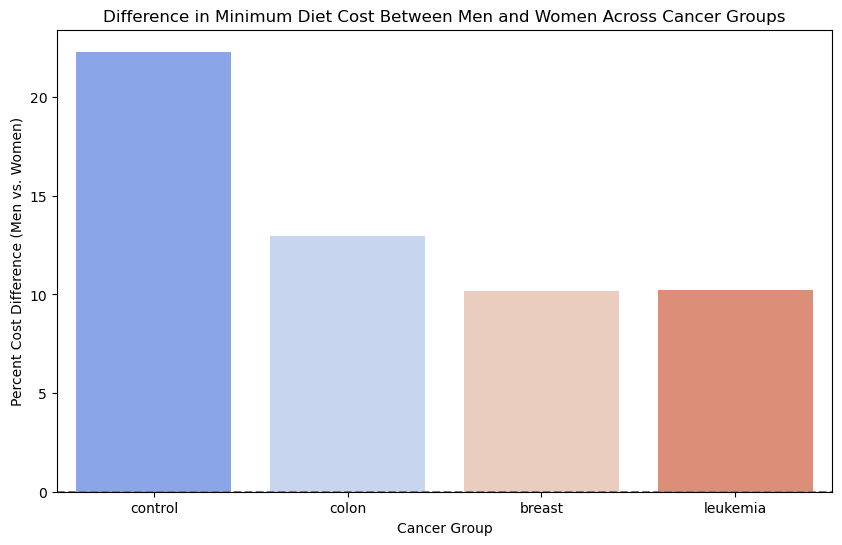

In [73]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_grouped, 
    x="Cancer Group", 
    y="% Difference (Male - Female)", 
    palette="coolwarm"
)

# Labels and title
plt.axhline(0, color="gray", linestyle="dashed")  # Reference line at 0
plt.xlabel("Cancer Group")
plt.ylabel("Percent Cost Difference (Men vs. Women)")
plt.title("Difference in Minimum Diet Cost Between Men and Women Across Cancer Groups")

# Show plot
plt.show()


In [74]:
control_costs = df_grouped[df_grouped["Cancer Group"] == "control"].set_index("Cancer Group")

# Create new columns for % change compared to control
df_grouped["% Change from Control (Female)"] = ((df_grouped["Female Cost"] - control_costs["Female Cost"].values[0]) / control_costs["Female Cost"].values[0]) * 100
df_grouped["% Change from Control (Male)"] = ((df_grouped["Male Cost"] - control_costs["Male Cost"].values[0]) / control_costs["Male Cost"].values[0]) * 100

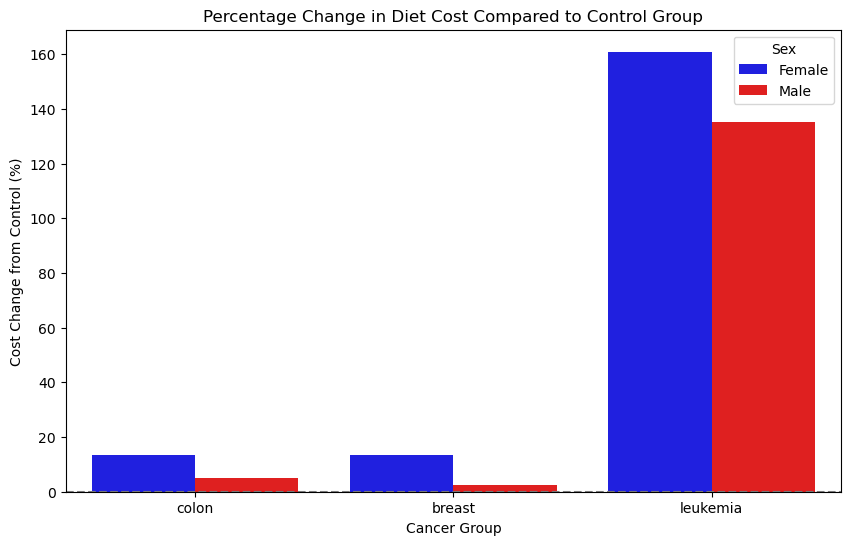

In [78]:

df_melted = df_grouped[df_grouped["Cancer Group"] != "control"].melt(id_vars=["Cancer Group"], 
                            value_vars=["% Change from Control (Female)", "% Change from Control (Male)"], 
                            var_name="Sex", 
                            value_name="% Change from Control")

df_melted["Sex"] = df_melted["Sex"].replace({
    "% Change from Control (Female)": "Female",
    "% Change from Control (Male)": "Male"
})

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="Cancer Group", y="% Change from Control", hue="Sex", palette=["blue", "red"])

plt.axhline(0, color="gray", linestyle="dashed")  # Reference line at 0%
plt.xlabel("Cancer Group")
plt.ylabel("Cost Change from Control (%)")
plt.title("Percentage Change in Diet Cost Compared to Control Group")
plt.legend(title="Sex")

# Show plot
plt.show()
